# Anomaly Detection on Bitcoin Prices  

## Overview  
This project aims to identify anomalies in Bitcoin prices during specific time windows, focusing on opening and closing prices. The dataset uses UNIX time as the time measurement standard. 

Dataset can be found here:  https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## Dataset  
The dataset includes the following labels:  
- **Timestamp**: When the data was recorded.  
- **Open**: The price at the start of the time window.  
- **High**: The highest price within the time window.  
- **Low**: The lowest price within the time window.  
- **Close**: The price at the end of the time window.  

## Objective  
The cryptocurrency market is known for its high volatility. At the conclusion of this project, we aim to determine which data points should be categorized as anomalies and which should be considered normal.  

## Models  
We will evaluate the performance of the following models to identify the most suitable approach for anomaly detection in this case:  
- **KNN (K-Nearest Neighbors)**  
- **LODA (Lightweight On-line Detector of Anomalies)**  
- **ABOD (Angle-Based Outlier Detection)**  
- **OCSVM (One-Class Support Vector Machine)**  

## Outcome  
The goal is to analyze and compare the performance of these models to conclude which is best suited for detecting anomalies in Bitcoin price data.  


## 1) We ensure to have all modules needed

In [15]:
# install python modules
!pip install pyod numpy pandas matplotlib kagglehub seaborn

## 2) Install our dataset from kaggle

In [16]:
# https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
print("Path to dataset files:", path)

Path to dataset files: /home/sorinalexb


## 3) Load the dataset and convert UNIX time to normal Timestamp

In [17]:
import pandas as pd
import numpy as np

d_path = f"{path}/btcusd_1-min_data.csv"
data = pd.read_csv(d_path)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')


print(data.head())

            Timestamp  Open  High   Low  Close  Volume
0 2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
3 2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
4 2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0


## 4) Verify what data is not valid

In [18]:
# find out how many entries from each label are null
print(data.isnull().sum(), end="\n\n")

# clear the null data
data.dropna(subset=['Timestamp'], inplace=True)

# check if we still have null entries
print(data.isnull().sum())

# show dimensions of our dataset
print(data.shape)

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64
(6718280, 6)


## 5) Get statistical insights of our labels

In [19]:
# we'll take a look at our dataset labels in order to see statistical insights about our data

print(f"'Open' label :\n{data['Open'].describe()}\n\n")
print(f"'High' label :\n{data['High'].describe()}\n\n")
print(f"'Low' label :\n{data['Low'].describe()}\n\n")
print(f"'Close' label :\n{data['Close'].describe()}\n\n")
print(f"'Volume' label :\n{data['Volume'].describe()}\n\n")

'Open' label :
count    6.718280e+06
mean     1.432311e+04
std      1.921874e+04
min      3.800000e+00
25%      4.118000e+02
50%      6.219450e+03
75%      2.298100e+04
max      9.899600e+04
Name: Open, dtype: float64


'High' label :
count    6.718280e+06
mean     1.432932e+04
std      1.922624e+04
min      3.800000e+00
25%      4.119800e+02
50%      6.222770e+03
75%      2.298700e+04
max      9.912100e+04
Name: High, dtype: float64


'Low' label :
count    6.718280e+06
mean     1.431672e+04
std      1.921112e+04
min      3.800000e+00
25%      4.116000e+02
50%      6.215890e+03
75%      2.297400e+04
max      9.895400e+04
Name: Low, dtype: float64


'Close' label :
count    6.718280e+06
mean     1.432314e+04
std      1.921884e+04
min      3.800000e+00
25%      4.118100e+02
50%      6.219355e+03
75%      2.298100e+04
max      9.899300e+04
Name: Close, dtype: float64


'Volume' label :
count    6.718280e+06
mean     5.475186e+00
std      2.297034e+01
min      0.000000e+00
25%      1.8243

## 6) Because our data is very volatile we need to normalize our dataset

In [20]:
from sklearn.preprocessing import MinMaxScaler
# in order to have a better accuracy we'll need to normalize our data
# given the fact that our categorical data is only float64 type we will
# extract information from our initial data variable where we store
# our dataset
categorical_data = data.select_dtypes(include=['float64'])

# for normalization we will use the Min-Max Scaler from sklearn
scaler = MinMaxScaler()

# call the scaler
normalized_data = scaler.fit_transform(categorical_data)

# convert the normalized_data to the standard data frame of our dataset
normalized_data = pd.DataFrame(normalized_data, columns=categorical_data.columns)

# print some data from the end of our categorical_data variable
# and normalized_data in order to observe the action of our scaler
print(categorical_data.tail())
print(normalized_data.tail())

# the only label that hasn't been normalized is the TimeStamp label which
# is irrealevant for us at this moment because we just want to select the
# anomalies from our dataset

            Open     High      Low    Close    Volume
6718275  97819.0  97821.0  97805.0  97805.0  0.028432
6718276  97768.0  97768.0  97767.0  97768.0  1.001276
6718277  97804.0  97804.0  97775.0  97775.0  1.081203
6718278  97775.0  97775.0  97775.0  97775.0  0.000000
6718279  97765.0  97765.0  97759.0  97759.0  0.384559
             Open      High       Low     Close    Volume
6718275  0.988110  0.986884  0.988388  0.987999  0.000005
6718276  0.987595  0.986349  0.988004  0.987625  0.000171
6718277  0.987959  0.986713  0.988085  0.987696  0.000185
6718278  0.987666  0.986420  0.988085  0.987696  0.000000
6718279  0.987565  0.986319  0.987923  0.987534  0.000066


## 7) Verify if our normalized data have faulty entries 

In [35]:
# visualization of normalized data
print(normalized_data.isnull().sum())
print(normalized_data.shape)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
(6718280, 5)


## 8) Build dunn_index function in order to get the dune index

In [22]:
from sklearn.metrics import pairwise_distances

# create dunn_index function in order to compute dunn
def dunn_index(X, labels):
    """
    Compute Dunn index for clusters in X using tags from labels

    :param X: Entry data (matrix of dimensions [n_samples, n_features])
    :param labels: Tags for every instance
    :return: Dunn index
    """

    # compute the maximal distance between points from the same cluster (cohesion)
    unique_labels = np.unique(labels)
    max_dist_within_cluster = -np.inf
    for label in unique_labels:
        # select current points from cluster
        cluster_points = X[labels == label]
        # compute the distance between every point from cluster
        dist_matrix = pairwise_distances(cluster_points)
        max_dist_within_cluster = max(max_dist_within_cluster, np.max(dist_matrix))

    # compute the minimal distance between different clusters (separability)
    min_dist_between_clusters = np.inf
    for i, label_i in enumerate(unique_labels):
        for label_j in unique_labels[i+1:]:
            # select points from different clusters
            cluster_i = X[labels == label_i]
            cluster_j = X[labels == label_j]
            # compute distance between points from different clusters
            dist_matrix = pairwise_distances(cluster_i, cluster_j)
            min_dist_between_clusters = min(min_dist_between_clusters, np.min(dist_matrix))

    # Dunn index is calculated using the division between separability and cohesion
    return min_dist_between_clusters / max_dist_within_cluster

## 9) We define calc_metrics_for_models function in order to compute and get as return the silhouette, dunn index and chesion values

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

# function to evaluate dunn, silhouette and cohesion based on sampled data
# and the scores of our models

def calc_metrics_for_models(sampled_data, anomaly_scores):

    # compute silhouette
    silhouette_avg = silhouette_score(sampled_data, anomaly_scores)

    # compute dunn
    dunn_value = dunn_index(sampled_data.values, anomaly_scores)

    # compute cohesion
    cohesion_value = np.mean(pairwise_distances(sampled_data))

    return silhouette_avg, dunn_value, cohesion_value

## 10) We want to create a new label for every entry which will tell us if it is an anomally or normal

In [24]:
from sklearn.cluster import KMeans

def apply_kmeans_for_labels(X, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels


## 11) Use Every Model on Our Dataset and Analyze Their Anomaly Estimations  

Our dataset is very large, so we will randomly sample **30,000 entries** to run the algorithms on. After applying the algorithms, we will obtain decision scores that indicate the anomaly score for each entry in the dataset.  

For each algorithm:  
- We will display the **top 5 anomalies** based on their anomaly scores.  
- We will cluster these anomalies using **K-Means** to gain further insights.  

We will use the `calc_metrics_for_models` function on the sampled data and the anomaly score list to evaluate the performance of each algorithm.  

In the end, we will gain insights into how effectively each algorithm detects anomalies.  


In [33]:
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.ocsvm import OCSVM
from pyod.models.loda import LODA
from sklearn.cluster import KMeans

# because our dataset is very large, we will just use 10000 entries
sample_size = 30000
sampled_data = normalized_data.sample(n=sample_size, random_state=42)

# we will compare four algorithms : KNN, ABOD, OCSVM, LODA
# resulting scores will be printed in oreder to be analysed

# define PyOD models
models = {
    'KNN': KNN(n_neighbors=300, method='largest'),
    'ABOD': ABOD(contamination=0.001),
    'OCSVM': OCSVM(kernel='linear', nu=0.1),
    'LODA': LODA(contamination=0.02)
}

scores = {}

# use algorithms on our data
for name, model in models.items():
    model.fit(sampled_data)
    scores[name] = model.decision_scores_

# create a dataframe for anomaly scores
scores_df = pd.DataFrame(scores)
scores_df = scores_df.fillna(0)

anomaly_labels = {model: KMeans(n_clusters=2,random_state=42).fit(scores_df[model].values.reshape(-1,1)).labels_ for model in models.keys()}

for model_name in models.keys():
    print(f"\nTop 5 anomalies for {model_name}:\n")
    print(scores_df[[model_name]].nlargest(5, model_name))
    stilhouette_avg, dunn_values, cohesion_value = calc_metrics_for_models(sampled_data, anomaly_labels[model_name])
    print(f"Dunn index for {model_name}: {dunn_values}")
    print(f"Stilhouette for {model_name}: {stilhouette_avg}")
    print(f"Cohesion for {model_name}: {cohesion_value}")

/home/sorinalexb/python_envs/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sorinalexb/python_envs/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sorinalexb/python_envs/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Top 5 anomalies for KNN:

            KNN
2693   0.616581
2029   0.611375
13690  0.610107
22789  0.609072
381    0.603088
Dunn index for KNN: 4.9441164613477935e-05
Stilhouette for KNN: 0.6428590986829532
Cohesion for KNN: 0.39134093476584514

Top 5 anomalies for ABOD:

    ABOD
1    0.0
11   0.0
20   0.0
35   0.0
45  -0.0
Dunn index for ABOD: 1.0105908780269882e-07
Stilhouette for ABOD: -0.4566539785689689
Cohesion for ABOD: 0.39134093476584514

Top 5 anomalies for OCSVM:

          OCSVM
6770   0.001201
7471   0.001201
9430   0.001201
13958  0.001201
22667  0.001201
Dunn index for OCSVM: 0.0002863117571284447
Stilhouette for OCSVM: 0.7626313087476657
Cohesion for OCSVM: 0.39134093476584514

Top 5 anomalies for LODA:

          LODA
381   0.077166
1801  0.077166
4069  0.077166
7272  0.077166
7384  0.077166
Dunn index for LODA: 5.0537231266520576e-05
Stilhouette for LODA: 0.7507509477377122
Cohesion for LODA: 0.39134093476584514


## 12) Our data has multiple labels so we will use PCA in order to plot our results in 2 dimensions. After conversion we plot the results

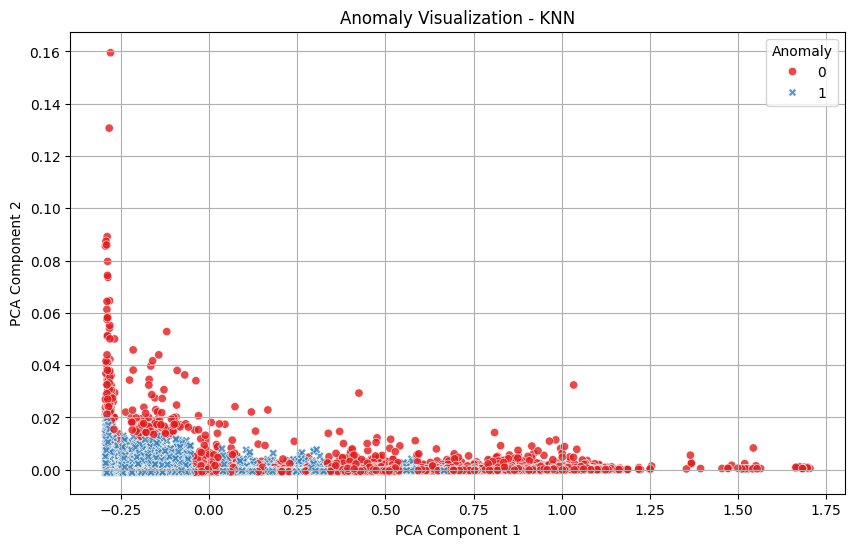

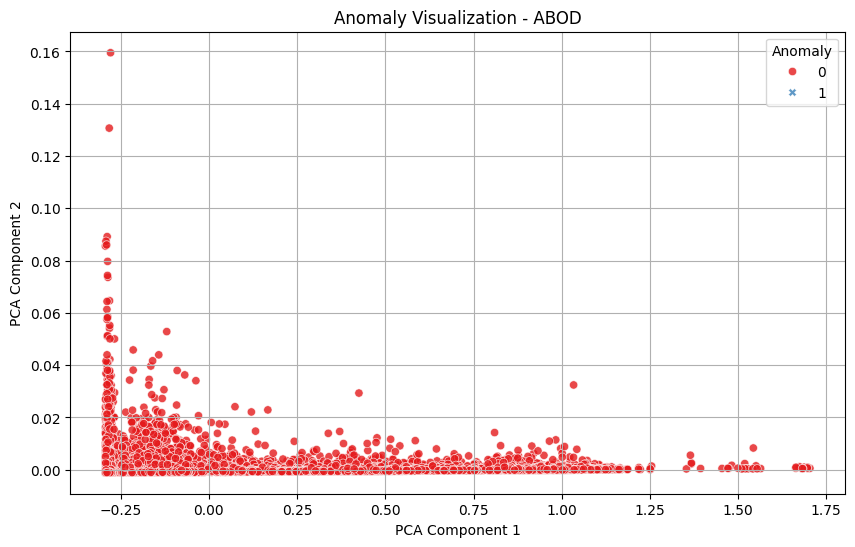

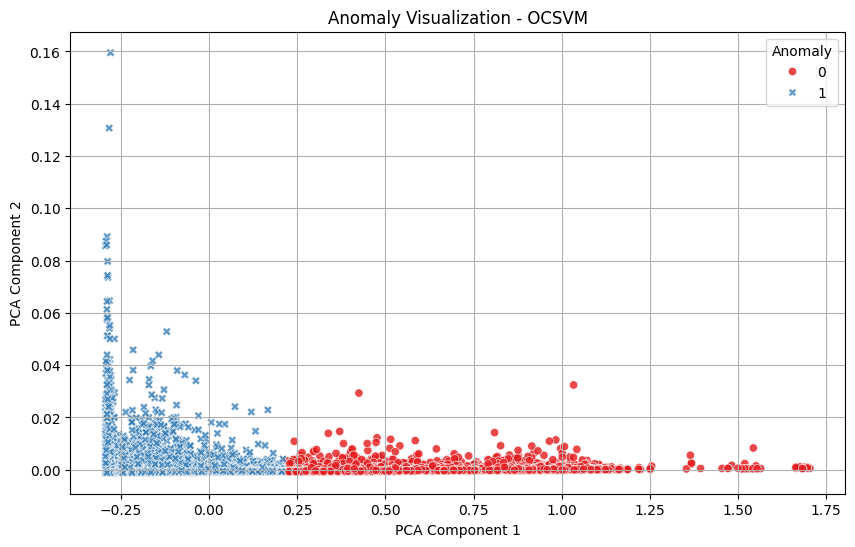

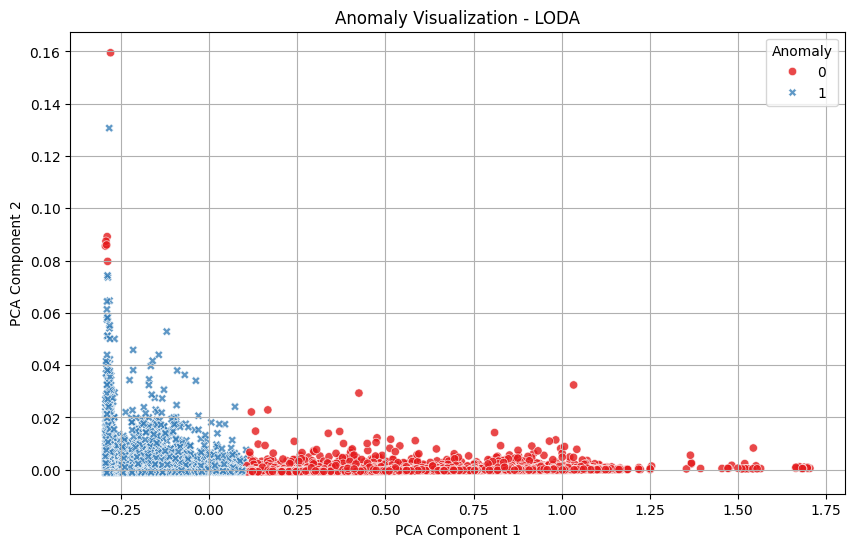

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Reducem dimensiunile folosind PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(sampled_data)

# Adăugăm etichetele de anomalie pentru KNN (de exemplu)
for model in models:
  labels = anomaly_labels[model]

  # Scatter plot cu anotări
  plt.figure(figsize=(10, 6))
  sns.scatterplot(
      x=reduced_data[:, 0], y=reduced_data[:, 1],
      hue=labels, palette="Set1", style=labels,
      markers=["o", "X"], alpha=0.8
  )
  plt.title(f"Anomaly Visualization - {model}")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  plt.legend(title="Anomaly")
  plt.grid(True)
  plt.show()



## Conclusions  

Based on the results, we can confidently conclude that **LODA** is the best-suited model for detecting anomalies in our dataset. The second-best match for our dataset is **KNN**, but it has some limitations, such as slight errors in visualization and a Dunn index that increases as the number of neighbors increases.  

**ABOD** failed to recognize any anomalies and demonstrated a poor silhouette value, indicating weak clustering performance. **OCSVM** produced visually appealing graphs, but its Dunn index is too low to meet our requirements.  

In conclusion, the best algorithm for detecting anomalies in our dataset is **LODA**.
